In [1]:
import sys
!{sys.executable} -m pip install statsmodels --no-index

Ignoring pip: markers 'python_version < "3"' don't match your environment
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionStyle
from matplotlib.lines import Line2D
from matplotlib import colors
import matplotlib.ticker as mticker
import re
import statsmodels.formula.api as smf


## 1. Help functions

In [3]:
def get_dp_overall(filename):
    df = pd.read_csv(filename, sep = '\t', comment = '#')
    return df

def get_dp_region(filename):
    df = pd.read_csv(filename, sep = '\t', comment = '#')
    return df

def get_n_reads_overall(filename):
    df = pd.read_csv(filename, sep = '\t', comment = '#')
    df['AVG_NOFILTER_BQ'] = df['N_NOFILTER_BQSUM'] / df['N_NOFILTER_BASES']
    df['AVG_BQ'] = df['N_BQSUM'] / df['N_BASES']
    df['AVG_MINQ_BQ'] = df['N_MINQ_BQSUM'] / df['N_MINQ_BASES']
    return df
    
# # Welch's t-test for equal mean (no requirement of same variance)
# def welchs_test(d1, d2, alternative = 'two-sided'):
#     stat, pvalue = stats.ttest_ind(d1, d2, equal_var = False, alternative = alternative)
#     return (stat, pvalue)

# # Permuted Brunner-Munzel test (generalize Mann–Whitney U test) for stochastic equality (no requirement for equal variances)
# def permuted_brunnermunzel(d1, d2, alternative = 'two-sided'):
#     with warnings.catch_warnings(record = True) as w:
#         observed = stats.brunnermunzel(d1, d2) # we need only statistics, which can have 'inf' values
#         n_combinations = 0
#         n_extreme_statistics = 0
#         d = np.concatenate((d1, d2))
#         for indices in map(np.array, combinations(range(0, len(d)), len(d1))):
#             n_combinations += 1
#             c1 = d[indices]
#             c2 = np.delete(d, indices)
#             permuted = stats.brunnermunzel(c1, c2)
#             if alternative == 'greater':
#                 if permuted.statistic <= observed.statistic:
#                     n_extreme_statistics += 1
#             elif alternative == 'less':
#                 if permuted.statistic >= observed.statistic:
#                     n_extreme_statistics += 1
#             else:
#                 if abs(permuted.statistic) >= abs(observed.statistic):
#                     n_extreme_statistics += 1
#     # print(w)
#     pvalue = n_extreme_statistics / n_combinations
#     return (observed.statistic, pvalue)

# def ftest_variance_less(d1, d2):
#     f_stat = np.var(d1, ddof=1) / np.var(d2, ddof=1)
#     p = stats.f.cdf(f_stat, len(d1) - 1, len(d2) - 1)
#     return (f_stat, p)

def annotate_pvalue(axes, x1, x2, y, value, fraction):
    display_coord1 = axes.transData.transform((x1, y))
    display_coord2 = axes.transData.transform((x2, y))
    display_dist = (display_coord2[0] - display_coord1[0]) * fraction
    text_y = axes.transData.inverted().transform((display_coord2[0] , display_coord2[1]  + display_dist))[1]
    if value >= 0.010:
        text = '$\it{p}='+ f'{value:.3f}' + '$'
    else:
        f = mticker.ScalarFormatter(useOffset = False, useMathText = True)
        f.set_powerlimits((-1, 1))
        text = "${}$".format(f.format_data(float(f'{value:.1e}'))).replace(' ', '')
        text = '$\it{p}=$' + re.sub('0+\\\\', '\\\\', text)
    axes.text(x1 + (x2 - x1) / 2, text_y, text, fontsize = 8, va = 'bottom', ha = 'center')
    axes.annotate('',
                  xy = (x1, y), xycoords = 'data', 
                  xytext= (x2, y), textcoords = 'data',
                  arrowprops = dict(arrowstyle = '-', connectionstyle = ConnectionStyle.Bar(armA = 0.0, armB = 0.0, fraction = fraction, angle = None))
                 )

def annotate_sample_size(axes, x, data, offset_y_px):
    max_y = max(data)
    n = len(data)
    display_coord = axes.transData.transform((x, max_y))
    text_y = axes.transData.inverted().transform((display_coord[0] , display_coord[1]  + offset_y_px))[1]
    axes.text(x, text_y, '$\it{n}$ = ' + f'{n}', fontsize = 8, va = 'bottom', ha = 'center')

def combine_values(df, suffix):
    for group, data in df.groupby(['CHROM', 'START', 'STOP', 'MIN_DP_N_ACGT', 'MIN_DP_N_GC']):
        yield { 'CHROM': group[0], 'START': group[1], 'STOP': group[2], 'N_ACGT': group[3], 'N_GC': group[4], f'AVG_DP{suffix}': list(data.MIN_DP_AVG_DP) }

def linkage_distance(df):
    for index, row in df.iterrows():
        n1 = len(row.AVG_DP_1)
        n4 = len(row.AVG_DP_4)
        n8 = len(row.AVG_DP_8)
        diff_sum_1vs4 = 0
        diff_sum_1vs8 = 0
        for v1 in row.AVG_DP_1:
            for v4 in row.AVG_DP_4:
                diff_sum_1vs4 += v1 - v4
            for v8 in row.AVG_DP_8:
                diff_sum_1vs8 += v1 - v8
        yield { 
            'CHROM': row.CHROM, 
            'START': row.START, 
            'STOP': row.STOP, 
            'N_ACGT': row.N_ACGT,
            'N_GC': row.N_GC, 
            'AVG_AVG_DP_1': np.mean(row.AVG_DP_1),
            'AVG_AVG_DP_4': np.mean(row.AVG_DP_4),
            'AVG_AVG_DP_8': np.mean(row.AVG_DP_8),
            'MEDIAN_AVG_DP_1': np.median(row.AVG_DP_1),
            'MEDIAN_AVG_DP_4': np.median(row.AVG_DP_4),
            'MEDIAN_AVG_DP_8': np.median(row.AVG_DP_8),
            'AVG_LINKAGE_AVG_DP_1vs4': diff_sum_1vs4 / (n1 * n4),
            'AVG_LINKAGE_AVG_DP_1vs8': diff_sum_1vs8 / (n1 * n8) 
        }

## 2. Input files

In [4]:
# Directories
OVERALL_DP_STATS_DIR = 'DP_and_reads_analysis/Overall_DP_stats'
REGION_DP_STATS_DIR = 'DP_and_reads_analysis/Region_DP_stats'
OVERALL_STATS_DIR = 'DP_and_reads_analysis/Overall_stats'
SAMPLE_ANNOTATIONS_FILE = 'sample_annotations.txt'


## 3. Load data

In [5]:
# Load sample annotations
df_samples = pd.read_csv(SAMPLE_ANNOTATIONS_FILE, header = 0, sep = '\t')

### 3.1. Load genome-wide DP

In [6]:
df_dp_noumi = []
for row_index, row in df_samples.iterrows():
    filepath = f'{OVERALL_DP_STATS_DIR}/WES_BAMs/{row.Plexing}plex/{row.Filename}.recal.bam.DP.tsv.gz.overal_stats.txt'
    df_dp = get_dp_overall(filepath).add_suffix('_NOUMI')
    df_dp['ID'] = row.Filename
    df_dp['HGID'] = row.HGID
    df_dp['Batch'] = row.Batch
    df_dp['Plexing'] = row.Plexing
    df_dp_noumi.append(df_dp)
df_dp_noumi = pd.concat(df_dp_noumi).reset_index(drop = True)

df_dp_umi = []
for row_index, row in df_samples.iterrows():
    filepath = f'{OVERALL_DP_STATS_DIR}/WES_BAMs_with_UMI_trimming/{row.Plexing}plex/{row.Filename}.sorted.dup.recal.bam.DP.tsv.gz.overal_stats.txt'
    df_dp = get_dp_overall(filepath).add_suffix('_UMI')
    df_dp['ID'] = row.Filename
    df_dp['HGID'] = row.HGID
    df_dp['Batch'] = row.Batch
    df_dp['Plexing'] = row.Plexing
    df_dp_umi.append(df_dp)
df_dp_umi = pd.concat(df_dp_umi).reset_index(drop = True)

df_dp_umi_gatk = []
for row_index, row in df_samples.iterrows():
    filepath = f'{OVERALL_DP_STATS_DIR}/WES_BAMs_with_UMI_trimming_GATK/{row.Plexing}plex/{row.Filename}.bam.DP.tsv.gz.overal_stats.txt'
    df_dp = get_dp_overall(filepath).add_suffix('_UMI_GATK')
    df_dp['ID'] = row.Filename
    df_dp['HGID'] = row.HGID
    df_dp['Batch'] = row.Batch
    df_dp['Plexing'] = row.Plexing
    df_dp_umi_gatk.append(df_dp)
df_dp_umi_gatk = pd.concat(df_dp_umi_gatk).reset_index(drop = True)

df_dp = df_dp_noumi.merge(df_dp_umi, on = ['ID', 'HGID', 'Batch', 'Plexing'])
df_dp = df_dp.merge(df_dp_umi_gatk, on = ['ID', 'HGID', 'Batch', 'Plexing'])


### 3.2. Load DP by target region

In [7]:
df_region_dp_noumi = {1: [], 4: [], 8: []}
for row_index, row in df_samples.iterrows():
    filepath = f'{REGION_DP_STATS_DIR}/WES_BAMs/{row.Plexing}plex/{row.Filename}.recal.bam.DP.tsv.gz.region_stats.txt'
    df = get_dp_region(filepath)
    df = df[['CHROM', 'START', 'STOP', 'MIN_DP_N_ACGT', 'MIN_DP_N_GC', 'MIN_DP_AVG_DP']].copy()
    df_region_dp_noumi[row.Plexing].append(df)
for plexing in [1, 4, 8]:
    df_region_dp_noumi[plexing] = pd.concat(df_region_dp_noumi[plexing]).reset_index(drop = True)


### 3.3. Load reads stats

In [8]:
df_n_reads_noumi = []
for row_index, row in df_samples.iterrows():
    filepath = f'{OVERALL_STATS_DIR}/WES_BAMs/{row.Plexing}plex/{row.Filename}.recal.bam.overall_stats.txt'
    df_n_reads = get_n_reads_overall(filepath).add_suffix('_NOUMI')
    df_n_reads['ID'] = row.Filename
    df_n_reads['HGID'] = row.HGID
    df_n_reads['Batch'] = row.Batch
    df_n_reads['Plexing'] = row.Plexing
    df_n_reads_noumi.append(df_n_reads)
df_n_reads_noumi = pd.concat(df_n_reads_noumi).reset_index(drop = True)

df_n_reads_umi = []
for row_index, row in df_samples.iterrows():
    filepath = f'{OVERALL_STATS_DIR}/WES_BAMs_with_UMI_trimming/{row.Plexing}plex/{row.Filename}.sorted.dup.recal.bam.overall_stats.txt'
    df_n_reads = get_n_reads_overall(filepath).add_suffix('_UMI')
    df_n_reads['ID'] = row.Filename
    df_n_reads['HGID'] = row.HGID
    df_n_reads['Batch'] = row.Batch
    df_n_reads['Plexing'] = row.Plexing
    df_n_reads_umi.append(df_n_reads)
df_n_reads_umi = pd.concat(df_n_reads_umi).reset_index(drop = True)

df_n_reads_umi_gatk = []
for row_index, row in df_samples.iterrows():
    filepath = f'{OVERALL_STATS_DIR}/WES_BAMs_with_UMI_trimming_GATK/{row.Plexing}plex/{row.Filename}.bam.overall_stats.txt'
    df_n_reads = get_n_reads_overall(filepath).add_suffix('_UMI_GATK')
    df_n_reads['ID'] = row.Filename
    df_n_reads['HGID'] = row.HGID
    df_n_reads['Batch'] = row.Batch
    df_n_reads['Plexing'] = row.Plexing
    df_n_reads_umi_gatk.append(df_n_reads)
df_n_reads_umi_gatk = pd.concat(df_n_reads_umi_gatk).reset_index(drop = True)

df_n_reads = df_n_reads_noumi.merge(df_n_reads_umi, on = ['ID', 'HGID', 'Batch', 'Plexing'])
df_n_reads = df_n_reads.merge(df_n_reads_umi_gatk, on = ['ID', 'HGID', 'Batch', 'Plexing'])

df_n_reads['N_READS_NOUMI_M'] = df_n_reads.N_NOFILTER_READS_NOUMI / 1000000
df_n_reads['N_READS_UMI_M'] = df_n_reads.N_NOFILTER_READS_UMI / 1000000
df_n_reads['N_READS_UMI_GATK_M'] = df_n_reads.N_NOFILTER_READS_UMI_GATK / 1000000
df_n_reads['PERC_DUPLICATED_READS_NOUMI'] = (df_n_reads.N_DUPLICATED_READS_NOUMI / df_n_reads.N_NOFILTER_READS_NOUMI) * 100
df_n_reads['PERC_DUPLICATED_READS_UMI'] = (df_n_reads.N_DUPLICATED_READS_UMI / df_n_reads.N_NOFILTER_READS_UMI) * 100
df_n_reads['PERC_DUPLICATED_READS_UMI_GATK'] = (df_n_reads.N_DUPLICATED_READS_UMI_GATK / df_n_reads.N_NOFILTER_READS_UMI_GATK) * 100
df_n_reads['PERC_UNMAPPED_READS_NOUMI'] = (df_n_reads.N_UNMAPPED_READS_NOUMI / df_n_reads.N_NOFILTER_READS_NOUMI) * 100
df_n_reads['PERC_UNMAPPED_READS_UMI'] = (df_n_reads.N_UNMAPPED_READS_UMI / df_n_reads.N_NOFILTER_READS_UMI) * 100
df_n_reads['PERC_UNMAPPED_READS_UMI_GATK'] = (df_n_reads.N_UNMAPPED_READS_UMI_GATK / df_n_reads.N_NOFILTER_READS_UMI_GATK) * 100
df_n_reads['PERC_QCFAIL_READS_NOUMI'] = (df_n_reads.N_QCFAIL_READS_NOUMI / df_n_reads.N_NOFILTER_READS_NOUMI) * 100
df_n_reads['PERC_QCFAIL_READS_UMI'] = (df_n_reads.N_QCFAIL_READS_UMI / df_n_reads.N_NOFILTER_READS_UMI) * 100
df_n_reads['PERC_QCFAIL_READS_UMI_GATK'] = (df_n_reads.N_QCFAIL_READS_UMI_GATK / df_n_reads.N_NOFILTER_READS_UMI_GATK) * 100


## 4. Figures and tables

### FIGURE: Average depths of coverage across all targeted regions in autosomal chromosomes in WES experiments without and with mutliplexing.

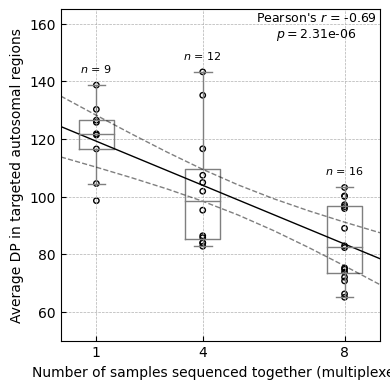

In [9]:
plt.style.use('default')
fig = plt.figure(figsize=(4, 4), dpi = 100)

# Run regression model
model = smf.ols('AVG_DP_NOUMI ~ Plexing', df_dp)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_dp.AVG_DP_NOUMI, df_dp.Plexing)

ax = fig.add_subplot(1, 1, 1)

# scatter plot
ax.scatter(df_dp.Plexing, df_dp.AVG_DP_NOUMI, facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_dp.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_dp[df_dp.Plexing == plexing].AVG_DP_NOUMI)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})


# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([50,  165])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)

ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.9), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('Average DP in targeted autosomal regions')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
    
plt.tight_layout()
plt.show()

### FIGURE: Comparison of average depths of coverage (DP) in individual target regions in experiments without  and with multiplexing.

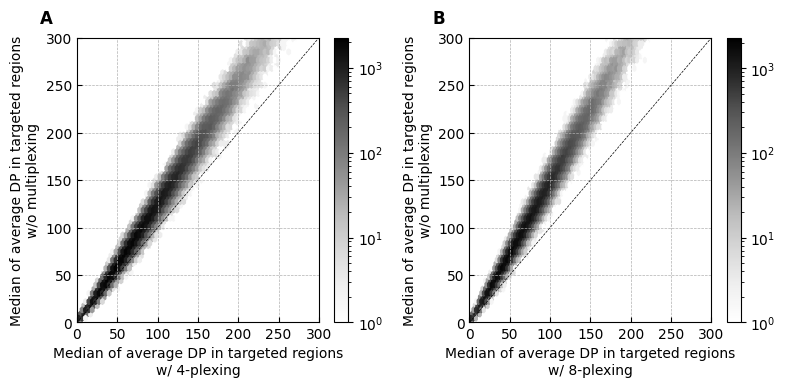

In [10]:
df1 = pd.DataFrame(combine_values(df_region_dp_noumi[1], '_1'))
df4 = pd.DataFrame(combine_values(df_region_dp_noumi[4], '_4'))
df8 = pd.DataFrame(combine_values(df_region_dp_noumi[8], '_8'))

df = df1.merge(df4, on = ['CHROM', 'START', 'STOP', 'N_ACGT', 'N_GC'])
df = df.merge(df8, on = ['CHROM', 'START', 'STOP', 'N_ACGT', 'N_GC'])

df = pd.DataFrame(linkage_distance(df))

plt.style.use('default')
fig = plt.figure(figsize=(8, 4), dpi = 100)

ax = fig.add_subplot(1, 2, 1)
hb = ax.hexbin(df['MEDIAN_AVG_DP_4'], df['MEDIAN_AVG_DP_1'], gridsize = 300, 
          norm = colors.LogNorm(),
          cmap ="Greys")
ax.axline((0, 0), (1, 1), linewidth = 0.5, linestyle = '--', color = 'black')
ax.set_xlim([0, 300])
ax.set_ylim([0, 300])
ax.set_xticks(range(0, 301, 50))
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
plt.colorbar(hb, ax = ax)
ax.set_ylabel('Median of average DP in targeted regions\nw/o multiplexing')
ax.set_xlabel('Median of average DP in targeted regions\nw/ 4-plexing')
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

ax = fig.add_subplot(1, 2, 2)
hb = ax.hexbin(df['MEDIAN_AVG_DP_8'], df['MEDIAN_AVG_DP_1'], gridsize = 300, 
          norm = colors.LogNorm(),
          cmap ="Greys")
ax.axline((0, 0), (1, 1), linewidth = 0.5, linestyle = '--', color = 'black')
ax.set_xlim([0, 300])
ax.set_ylim([0, 300])
ax.set_xticks(range(0, 301, 50))
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
plt.colorbar(hb, ax = ax)
ax.set_ylabel('Median of average DP in targeted regions\nw/o multiplexing')
ax.set_xlabel('Median of average DP in targeted regions\nw/ 8-plexing')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

plt.tight_layout()
plt.show()

### FIGURE: Average depths of coverage across all targeted regions in autosomal chromosomes stratified by library preparation batch.

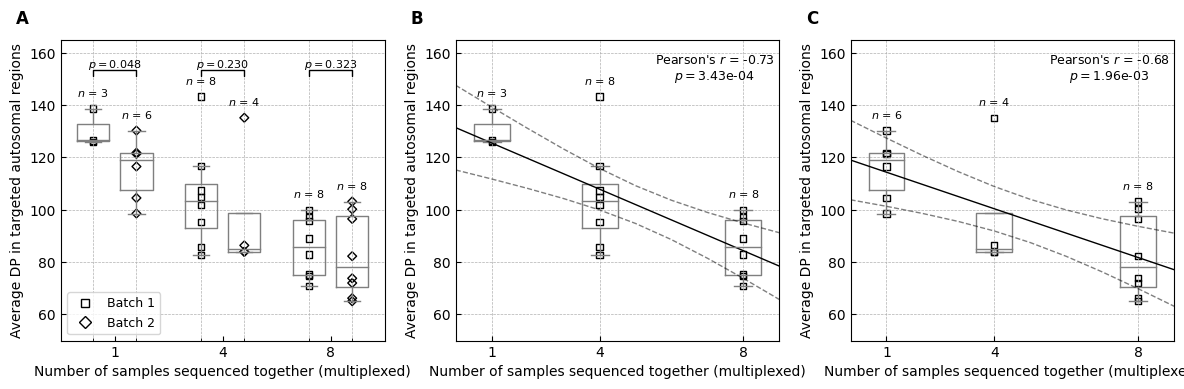

In [11]:
plt.style.use('default')
fig = plt.figure(figsize=(12, 4), dpi = 100)


# FIGURE A.
ax = fig.add_subplot(1, 3, 1)

batches = [1, 2]
batch_colors = { 1: 'tab:blue', 2: 'tab:orange' }
batch_markers = { 1: 's', 2: 'D' }
batch_offsets = { 1: -0.2, 2: 0.2 }
plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

# scatter plot
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_dp_temp = df_dp[(df_dp.Batch == batch) & (df_dp.Plexing == plexing)]
        ax.scatter([x + batch_offsets[batch]] * len(df_dp_temp), df_dp_temp.AVG_DP_NOUMI, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = {1: [], 2: []}
bp_positions = {1: [], 2: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_dp_temp = df_dp[(df_dp.Batch == batch) & (df_dp.Plexing == plexing)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_dp_temp.AVG_DP_NOUMI)
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.3,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
    
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([50, 165])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x in plexing_positions] + [x + batch_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)

# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
        
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})

ax.set_ylabel('Average DP in targeted autosomal regions')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for i, x in enumerate(plexing_positions, 0):
    pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "greater")[1]
    annotate_pvalue(ax, x - 0.2, x + 0.2, 150, pvalue, 0.20)
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE B.
ax = fig.add_subplot(1, 3, 2)

df_dp1 = df_dp[df_dp.Batch == 1].copy()

# Run regression model
model = smf.ols('AVG_DP_NOUMI ~ Plexing', df_dp1)
res = model.fit()

a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_dp1.AVG_DP_NOUMI, df_dp1.Plexing)

# scatter plot
ax.scatter(df_dp1.Plexing, df_dp1.AVG_DP_NOUMI, marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_dp1.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_dp1[df_dp1.Plexing == plexing].AVG_DP_NOUMI)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)


# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([50,  165])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('Average DP in targeted autosomal regions')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
ax = fig.add_subplot(1, 3, 3)

df_dp2 = df_dp[df_dp.Batch == 2].copy()

# Run quantile regression model
model = smf.ols('AVG_DP_NOUMI ~ Plexing', df_dp2)
res = model.fit()

a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_dp2.AVG_DP_NOUMI, df_dp2.Plexing)

# scatter plot
ax.scatter(df_dp2.Plexing, df_dp2.AVG_DP_NOUMI, marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_dp2.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_dp2[df_dp2.Plexing == plexing].AVG_DP_NOUMI)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([50,  165])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('Average DP in targeted autosomal regions')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
    
plt.tight_layout()
plt.show()

### FIGURE: Number of reads in autosomal chromosomes in sequencing experiments with and without multiplexing.

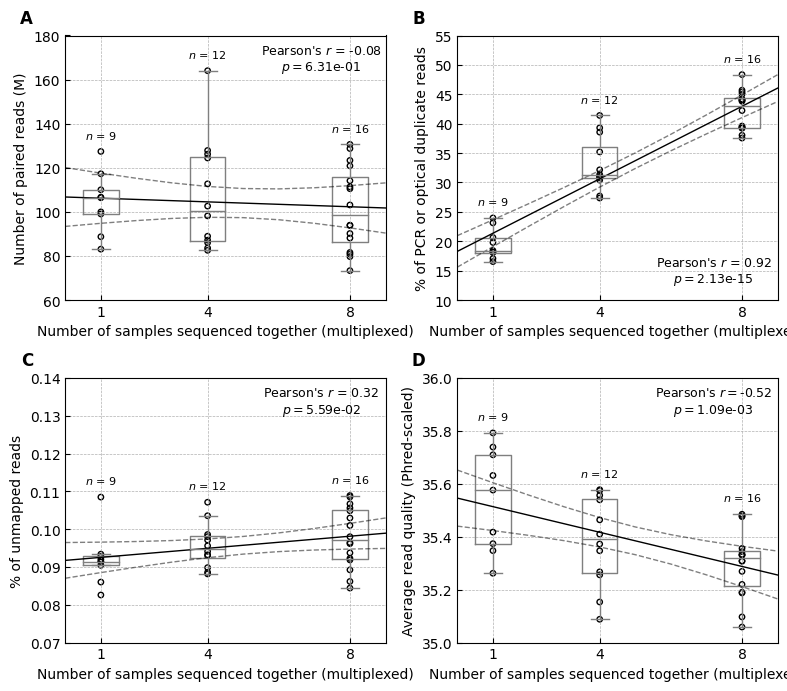

In [12]:
plt.style.use('default')
fig = plt.figure(figsize=(8, 7), dpi = 100)

# Figure A

# Run regression model
model = smf.ols('N_READS_NOUMI_M ~ Plexing', df_n_reads)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_n_reads.N_READS_NOUMI_M, df_n_reads.Plexing)

ax = fig.add_subplot(2, 2, 1)

# scatter plot
ax.scatter(df_n_reads.Plexing, df_n_reads.N_READS_NOUMI_M, facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_n_reads.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_n_reads[df_n_reads.Plexing == plexing].N_READS_NOUMI_M)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([60,  180])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)

ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('Number of paired reads (M)')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

# Figure B

# Run regression model
model = smf.ols('PERC_DUPLICATED_READS_NOUMI ~ Plexing', df_n_reads)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_n_reads.PERC_DUPLICATED_READS_NOUMI, df_n_reads.Plexing)

ax = fig.add_subplot(2, 2, 2)

# scatter plot
ax.scatter(df_n_reads.Plexing, df_n_reads.PERC_DUPLICATED_READS_NOUMI, facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_n_reads.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_n_reads[df_n_reads.Plexing == plexing].PERC_DUPLICATED_READS_NOUMI)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([10,  55])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)

ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.05), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('% of PCR or optical duplicate reads')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# Figure C

# Run quantile regression model
model = smf.ols('PERC_UNMAPPED_READS_NOUMI ~ Plexing', df_n_reads)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_n_reads.PERC_UNMAPPED_READS_NOUMI, df_n_reads.Plexing)

ax = fig.add_subplot(2, 2, 3)

# scatter plot
ax.scatter(df_n_reads.Plexing, df_n_reads.PERC_UNMAPPED_READS_NOUMI, facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_n_reads.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_n_reads[df_n_reads.Plexing == plexing].PERC_UNMAPPED_READS_NOUMI)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)


# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.07,  0.14])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.set_ylabel('% of unmapped reads')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# Figure D

# Run quantile regression model
model = smf.ols('AVG_BQ_NOUMI ~ Plexing', df_n_reads)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_n_reads.AVG_BQ_NOUMI, df_n_reads.Plexing)

ax = fig.add_subplot(2, 2, 4)

# scatter plot
ax.scatter(df_n_reads.Plexing, df_n_reads.AVG_BQ_NOUMI, facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_n_reads.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_n_reads[df_n_reads.Plexing == plexing].AVG_BQ_NOUMI)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([35,  36])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)

ax.annotate(
    'Pearson\'s $\it{r}=$' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('Average read quality (Phred-scaled)')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

plt.tight_layout()
plt.show()

### FIGURE: Number of paired reads in autosomal chromosomes stratified by library preparation batch.

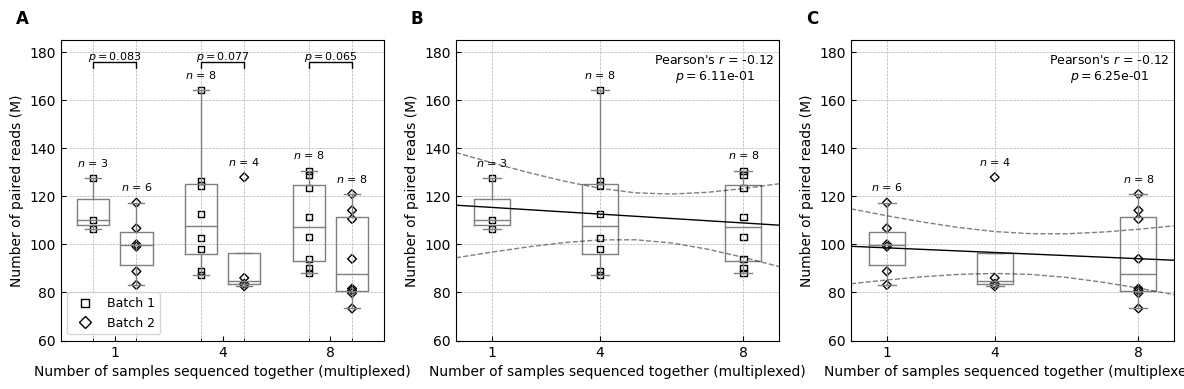

In [13]:
plt.style.use('default')
fig = plt.figure(figsize=(12, 4), dpi = 100)

# FIGURE A.
ax = fig.add_subplot(1, 3, 1)

batches = [1, 2]
batch_colors = { 1: 'tab:blue', 2: 'tab:orange' }
batch_markers = { 1: 's', 2: 'D' }
batch_offsets = { 1: -0.2, 2: 0.2 }
plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

# scatter plot
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Batch == batch) & (df_n_reads.Plexing == plexing)]
        ax.scatter([x + batch_offsets[batch]] * len(df_n_reads_temp), df_n_reads_temp.N_READS_NOUMI_M, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = {1: [], 2: []}
bp_positions = {1: [], 2: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Batch == batch) & (df_n_reads.Plexing == plexing)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_n_reads_temp.N_READS_NOUMI_M)
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.3,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
    
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([60,  185])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x in plexing_positions] + [x + batch_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)

# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
        
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})

ax.set_ylabel('Number of paired reads (M)')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for i, x in enumerate(plexing_positions, 0):
    pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "greater")[1]
    annotate_pvalue(ax, x - 0.2, x + 0.2, 172, pvalue, 0.20)
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# # FIGURE B.
ax = fig.add_subplot(1, 3, 2)

df_n_reads1 = df_n_reads[df_n_reads.Batch == 1].copy()

# Run regression model
model = smf.ols('N_READS_NOUMI_M ~ Plexing', df_n_reads1)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_n_reads1.N_READS_NOUMI_M, df_n_reads1.Plexing)

# scatter plot
ax.scatter(df_n_reads1.Plexing, df_n_reads1.N_READS_NOUMI_M, marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_n_reads1.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_n_reads1[df_n_reads1.Plexing == plexing].N_READS_NOUMI_M)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([60,  185])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('Number of paired reads (M)')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
ax = fig.add_subplot(1, 3, 3)

df_n_reads2 = df_n_reads[df_n_reads.Batch == 2].copy()

# Run regression model
model = smf.ols('N_READS_NOUMI_M ~ Plexing', df_n_reads2)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_n_reads2.N_READS_NOUMI_M, df_n_reads2.Plexing)

# scatter plot
ax.scatter(df_n_reads2.Plexing, df_n_reads2.N_READS_NOUMI_M, marker = batch_markers[2], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_n_reads2.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_n_reads2[df_n_reads2.Plexing == plexing].N_READS_NOUMI_M)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([60,  185])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('Number of paired reads (M)')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
    
plt.tight_layout()
plt.show()



### FIGURE: Percent of reads flagged as PCR or optical duplicates in autosomal chromosomes stratified by library preparation batch.

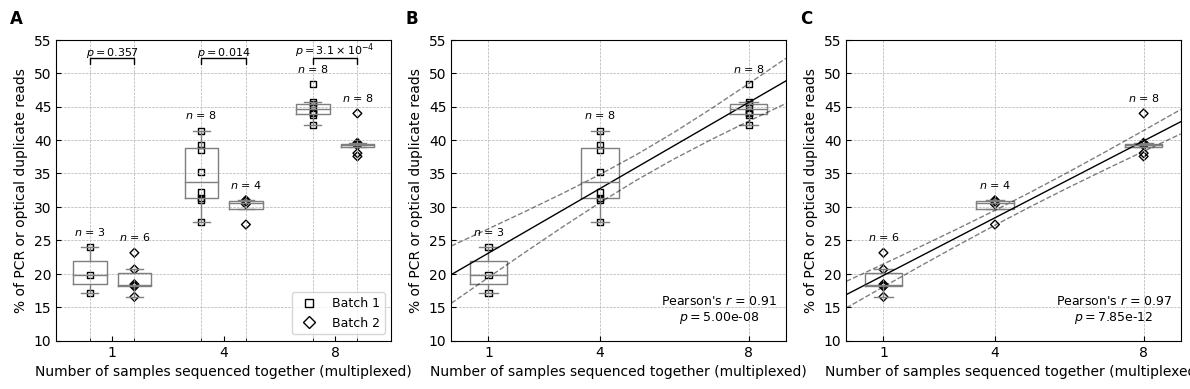

In [14]:
plt.style.use('default')
fig = plt.figure(figsize=(12, 4), dpi = 100)

# FIGURE A.
ax = fig.add_subplot(1, 3, 1)

batches = [1, 2]
batch_colors = { 1: 'tab:blue', 2: 'tab:orange' }
batch_markers = { 1: 's', 2: 'D' }
batch_offsets = { 1: -0.2, 2: 0.2 }
plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

# scatter plot
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Batch == batch) & (df_n_reads.Plexing == plexing)]
        ax.scatter([x + batch_offsets[batch]] * len(df_n_reads_temp), df_n_reads_temp.PERC_DUPLICATED_READS_NOUMI, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = {1: [], 2: []}
bp_positions = {1: [], 2: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Batch == batch) & (df_n_reads.Plexing == plexing)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_n_reads_temp.PERC_DUPLICATED_READS_NOUMI)
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.3,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
    
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([10,  55])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x in plexing_positions] + [x + batch_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)

# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
        
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 4, prop = {'size': 9})

ax.set_ylabel('% of PCR or optical duplicate reads')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for i, x in enumerate(plexing_positions, 0):
    pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "greater")[1]
    annotate_pvalue(ax, x - 0.2, x + 0.2, 51, pvalue, 0.20)
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# # FIGURE B.
ax = fig.add_subplot(1, 3, 2)

df_n_reads1 = df_n_reads[df_n_reads.Batch == 1].copy()

# Run regression model
model = smf.ols('PERC_DUPLICATED_READS_NOUMI ~ Plexing', df_n_reads1)
res = model.fit()

a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_n_reads1.PERC_DUPLICATED_READS_NOUMI, df_n_reads1.Plexing)

# scatter plot
ax.scatter(df_n_reads1.Plexing, df_n_reads1.PERC_DUPLICATED_READS_NOUMI, marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_n_reads1.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_n_reads1[df_n_reads1.Plexing == plexing].PERC_DUPLICATED_READS_NOUMI)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([10,  55])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('% of PCR or optical duplicate reads')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.05), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
ax = fig.add_subplot(1, 3, 3)

df_n_reads2 = df_n_reads[df_n_reads.Batch == 2].copy()

# Run regression model
model = smf.ols('PERC_DUPLICATED_READS_NOUMI ~ Plexing', df_n_reads2)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_n_reads2.PERC_DUPLICATED_READS_NOUMI, df_n_reads2.Plexing)

# scatter plot
ax.scatter(df_n_reads2.Plexing, df_n_reads2.PERC_DUPLICATED_READS_NOUMI, marker = batch_markers[2], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_n_reads2.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_n_reads2[df_n_reads2.Plexing == plexing].PERC_DUPLICATED_READS_NOUMI)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([10,  55])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('% of PCR or optical duplicate reads')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.05), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
    
plt.tight_layout()
plt.show()


### FIGURE: Percent of unmapped reads in autosomal chromosomes stratified by library preparation batch.

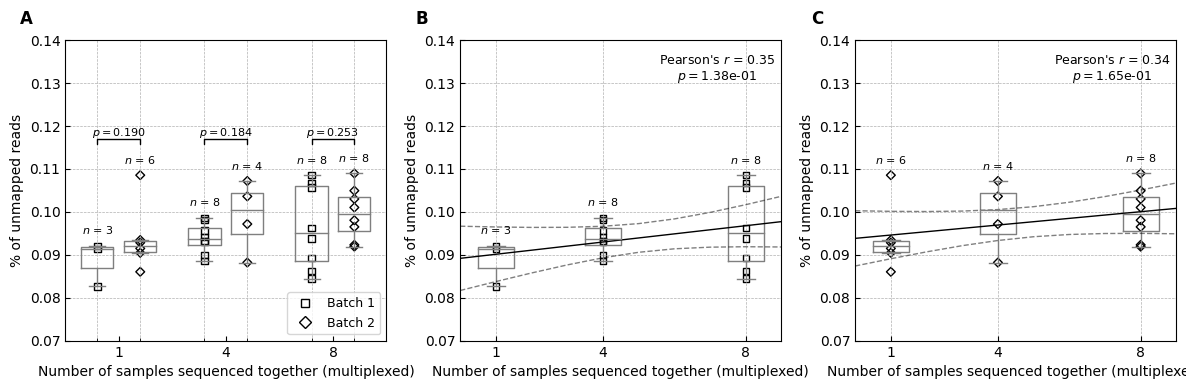

In [15]:
plt.style.use('default')
fig = plt.figure(figsize=(12, 4), dpi = 100)

# FIGURE A.
ax = fig.add_subplot(1, 3, 1)

batches = [1, 2]
batch_colors = { 1: 'tab:blue', 2: 'tab:orange' }
batch_markers = { 1: 's', 2: 'D' }
batch_offsets = { 1: -0.2, 2: 0.2 }
plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

# scatter plot
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Batch == batch) & (df_n_reads.Plexing == plexing)]
        ax.scatter([x + batch_offsets[batch]] * len(df_n_reads_temp), df_n_reads_temp.PERC_UNMAPPED_READS_NOUMI, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = {1: [], 2: []}
bp_positions = {1: [], 2: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Batch == batch) & (df_n_reads.Plexing == plexing)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_n_reads_temp.PERC_UNMAPPED_READS_NOUMI)
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.3,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
    
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.07,  0.14])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x in plexing_positions] + [x + batch_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)

# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
        
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 4, prop = {'size': 9})

ax.set_ylabel('% of unmapped reads')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for i, x in enumerate(plexing_positions, 0):
    pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "less")[1]
    annotate_pvalue(ax, x - 0.2, x + 0.2, 0.115, pvalue, 0.20)
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# # FIGURE B.
ax = fig.add_subplot(1, 3, 2)

df_n_reads1 = df_n_reads[df_n_reads.Batch == 1].copy()

# Run regression model
model = smf.ols('PERC_UNMAPPED_READS_NOUMI ~ Plexing', df_n_reads1)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_n_reads1.PERC_UNMAPPED_READS_NOUMI, df_n_reads1.Plexing)

# scatter plot
ax.scatter(df_n_reads1.Plexing, df_n_reads1.PERC_UNMAPPED_READS_NOUMI, marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_n_reads1.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_n_reads1[df_n_reads1.Plexing == plexing].PERC_UNMAPPED_READS_NOUMI)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.07,  0.14])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('% of unmapped reads')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
ax = fig.add_subplot(1, 3, 3)

df_n_reads2 = df_n_reads[df_n_reads.Batch == 2].copy()

# Run regression model
model = smf.ols('PERC_UNMAPPED_READS_NOUMI ~ Plexing', df_n_reads2)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_n_reads2.PERC_UNMAPPED_READS_NOUMI, df_n_reads2.Plexing)

# scatter plot
ax.scatter(df_n_reads2.Plexing, df_n_reads2.PERC_UNMAPPED_READS_NOUMI, marker = batch_markers[2], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_n_reads2.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_n_reads2[df_n_reads2.Plexing == plexing].PERC_UNMAPPED_READS_NOUMI)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.07,  0.14])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('% of unmapped reads')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
    
plt.tight_layout()
plt.show()


### FIGURE: Average quality of reads in autosomal chromosomes stratified by library preparation batch.

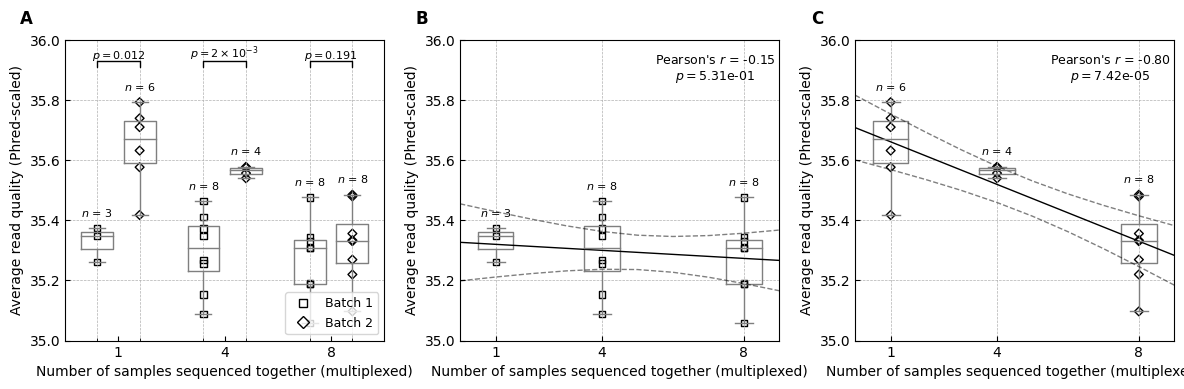

In [16]:
plt.style.use('default')
fig = plt.figure(figsize=(12, 4), dpi = 100)

# FIGURE A.
ax = fig.add_subplot(1, 3, 1)

batches = [1, 2]
batch_colors = { 1: 'tab:blue', 2: 'tab:orange' }
batch_markers = { 1: 's', 2: 'D' }
batch_offsets = { 1: -0.2, 2: 0.2 }
plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

# scatter plot
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Batch == batch) & (df_n_reads.Plexing == plexing)]
        ax.scatter([x + batch_offsets[batch]] * len(df_n_reads_temp), df_n_reads_temp.AVG_BQ_NOUMI, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = {1: [], 2: []}
bp_positions = {1: [], 2: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Batch == batch) & (df_n_reads.Plexing == plexing)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_n_reads_temp.AVG_BQ_NOUMI)
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.3,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
    
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([35,  36])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x in plexing_positions] + [x + batch_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)

# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
        
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 4, prop = {'size': 9})

ax.set_ylabel('Average read quality (Phred-scaled)')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for i, x in enumerate(plexing_positions, 0):
    pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "less")[1]
    annotate_pvalue(ax, x - 0.2, x + 0.2, 35.9, pvalue, 0.20)
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE B.
ax = fig.add_subplot(1, 3, 2)

df_n_reads1 = df_n_reads[df_n_reads.Batch == 1].copy()

# Run regression model
model = smf.ols('AVG_BQ_NOUMI ~ Plexing', df_n_reads1)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_n_reads1.AVG_BQ_NOUMI, df_n_reads1.Plexing)

# scatter plot
ax.scatter(df_n_reads1.Plexing, df_n_reads1.AVG_BQ_NOUMI, marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_n_reads1.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_n_reads1[df_n_reads1.Plexing == plexing].AVG_BQ_NOUMI)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([35,  36])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('Average read quality (Phred-scaled)')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
ax = fig.add_subplot(1, 3, 3)

df_n_reads2 = df_n_reads[df_n_reads.Batch == 2].copy()

# Run regression model
model = smf.ols('AVG_BQ_NOUMI ~ Plexing', df_n_reads2)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_n_reads2.AVG_BQ_NOUMI, df_n_reads2.Plexing)

# scatter plot
ax.scatter(df_n_reads2.Plexing, df_n_reads2.AVG_BQ_NOUMI, marker = batch_markers[2], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_n_reads2.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_n_reads2[df_n_reads2.Plexing == plexing].AVG_BQ_NOUMI)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([35,  36])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('Average read quality (Phred-scaled)')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
    
plt.tight_layout()
plt.show()


### FIGURE: Average depths of coverage across all targeted regions in autosomal chromosomes processed with and without UMI-aware deduplication.

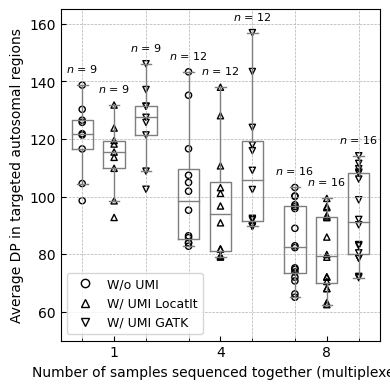

In [17]:
plt.style.use('default')
fig = plt.figure(figsize=(4, 4), dpi = 100)

dedup_types = [(1, 'NOUMI'), (2, 'UMI'), (3, 'UMI_GATK')]
dedup_markers = { 1: 'o', 2: '^', 3: 'v' }
dedup_offsets = { 1: -0.3, 2: 0, 3: 0.3}
plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

ax = fig.add_subplot(1, 1, 1)

for dedup_idx, dedup_type in dedup_types:
    for x, plexing in zip(plexing_positions, plexings):
        df_dp_temp = df_dp[(df_dp.Plexing == plexing)]
        ax.scatter([x + dedup_offsets[dedup_idx]] * len(df_dp_temp), df_dp_temp[f'AVG_DP_{dedup_type}'], 
                marker = dedup_markers[dedup_idx], edgecolor = 'black', facecolor = 'none', s = 20)
# boxplots
bp_data = {1: [], 2: [], 3: []}
bp_positions = {1: [], 2: [], 3: []}
for dedup_idx, dedup_type in dedup_types:
    for x, plexing in zip(plexing_positions, plexings):
        df_dp_temp = df_dp[(df_dp.Plexing == plexing)]
        bp_positions[dedup_idx].append(x + dedup_offsets[dedup_idx])
        bp_data[dedup_idx].append(df_dp_temp[f'AVG_DP_{dedup_type}'])
    bx = ax.boxplot(bp_data[dedup_idx], positions = bp_positions[dedup_idx], widths = 0.2,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + dedup_offsets[1] for x in plexing_positions] + [x + dedup_offsets[2] for x in plexing_positions] + [x + dedup_offsets[3] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([50,  165])
# Text annotations
for dedup_idx, dedup_type in dedup_types:
    for x, data in zip(bp_positions[dedup_idx], bp_data[dedup_idx]):
        annotate_sample_size(ax, x, data, 10)
ax.set_ylabel('Average DP in targeted autosomal regions')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = dedup_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = dedup_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI LocatIt'),
    Line2D([0], [0], marker = dedup_markers[3], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI GATK')
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
    
plt.tight_layout()
plt.show()

### TABLE: The average changes in read properties after UMI-aware read deduplication steps relative to the UMI agnostic approach.

In [18]:
dedup_types = [('UMI', 'LocatIt'), ('UMI_GATK', 'GATK')]
plexings = [1, 4, 8]

data = {
    'Number of samples sequenced together (multiplexed)': [],
    'UMI-aware deduplication tool': [],
    'Millions of reads (SE)': [],
    '% of QC fail reads (SE)': [],
    '% of PCR/optical duplicates (SE)': [],
    '% of unmapped reads (SE)': [],
    'Avg. Phred-scaled read quality (SE)': []
}

for plexing in plexings:
    df_temp = df_n_reads[(df_n_reads.Plexing == plexing)]
    for dedup_type, dedup_label in dedup_types:
        data['Number of samples sequenced together (multiplexed)'].append(plexing)
        data['UMI-aware deduplication tool'].append(dedup_label)
        
        avg = np.mean(df_temp[f'N_READS_{dedup_type}_M'] - df_temp['N_READS_NOUMI_M'])
        sem = stats.sem(df_temp[f'N_READS_{dedup_type}_M'] - df_temp['N_READS_NOUMI_M'])
        data['Millions of reads (SE)'].append(f'{avg:.2f} ({sem:.2f})')
        
        avg = np.mean(df_temp[f'PERC_QCFAIL_READS_{dedup_type}'] - df_temp['PERC_QCFAIL_READS_NOUMI'])
        sem = stats.sem(df_temp[f'PERC_QCFAIL_READS_{dedup_type}'] - df_temp['PERC_QCFAIL_READS_NOUMI'])
        data['% of QC fail reads (SE)'].append(f'{avg:.2f} ({sem:.2f})')
        
        avg = np.mean(df_temp[f'PERC_DUPLICATED_READS_{dedup_type}'] - df_temp['PERC_DUPLICATED_READS_NOUMI'])
        sem = stats.sem(df_temp[f'PERC_DUPLICATED_READS_{dedup_type}'] - df_temp['PERC_DUPLICATED_READS_NOUMI'])
        data['% of PCR/optical duplicates (SE)'].append(f'{avg:.2f} ({sem:.2f})')
        
        avg = np.mean(df_temp[f'PERC_UNMAPPED_READS_{dedup_type}'] - df_temp['PERC_UNMAPPED_READS_NOUMI'])
        sem = stats.sem(df_temp[f'PERC_UNMAPPED_READS_{dedup_type}'] - df_temp['PERC_UNMAPPED_READS_NOUMI'])
        data['% of unmapped reads (SE)'].append(f'{avg:.3f} ({sem:.5f})')
        
        avg = np.mean(df_temp[f'AVG_BQ_{dedup_type}'] - df_temp['AVG_BQ_NOUMI'])
        sem = stats.sem(df_temp[f'AVG_BQ_{dedup_type}'] - df_temp['AVG_BQ_NOUMI'])
        data['Avg. Phred-scaled read quality (SE)'].append(f'{avg:.2f} ({sem:.2f})')

pd.DataFrame(data)


,Number of samples sequenced together (multiplexed),UMI-aware deduplication tool,Millions of reads (SE),% of QC fail reads (SE),% of PCR/optical duplicates (SE),% of unmapped reads (SE),Avg. Phred-scaled read quality (SE)
0,1,LocatIt,-0.01 (0.00),6.45 (0.16),-1.20 (0.04),-0.068 (0.00223),2.60 (0.12)
1,1,GATK,-0.01 (0.00),0.00 (0.00),-0.36 (0.01),0.003 (0.00003),0.35 (0.06)
2,4,LocatIt,-0.01 (0.00),5.19 (0.16),-1.42 (0.04),-0.069 (0.00159),2.87 (0.05)
3,4,GATK,-0.01 (0.00),0.00 (0.00),-0.39 (0.01),0.003 (0.00005),0.49 (0.05)
4,8,LocatIt,-0.01 (0.00),4.38 (0.10),-1.56 (0.03),-0.069 (0.00175),2.70 (0.14)
5,8,GATK,-0.01 (0.00),0.00 (0.00),-0.40 (0.01),0.003 (0.00004),0.57 (0.03)


### EXTRA TABLE: Average read properties across all targeted regions in autosomal chromosomes processed with and without UMI-aware deduplication.

In [19]:
dedup_types = [('NOUMI', 'W/o UMI'), ('UMI', 'W/ UMI LocatIt'), ('UMI_GATK', 'W/ UMI GATK')]
plexings = [1, 4, 8]

data = {
    'Number of samples': [],
    'Deduplication': [],
    'Avg. number of reads (M)': [],
    'Avg. % of QC fail reads': [],
    'Avg. % of PCR/optical duplicates': [],
    'Avg. % of unmapped reads': [],
    'Avg. read quality (Phred-scaled)': []
    
}
n_multiplexed_samples = []
deduplications = []
for plexing in plexings:
    for dedup_type, dedup_label in dedup_types:
        data['Number of samples'].append(plexing)
        data['Deduplication'].append(dedup_label)
        
        avg = df_n_reads[(df_n_reads.Plexing == plexing)][f'N_READS_{dedup_type}_M'].mean()
        sem = df_n_reads[(df_n_reads.Plexing == plexing)][f'N_READS_{dedup_type}_M'].sem()
        data['Avg. number of reads (M)'].append(f'{avg:.2f} ({sem:.2f})')
        
        avg = df_n_reads[(df_n_reads.Plexing == plexing)][f'PERC_QCFAIL_READS_{dedup_type}'].mean()
        sem = df_n_reads[(df_n_reads.Plexing == plexing)][f'PERC_QCFAIL_READS_{dedup_type}'].sem()
        data['Avg. % of QC fail reads'].append(f'{avg:.2f} ({sem:.2f})')
        
        avg = df_n_reads[(df_n_reads.Plexing == plexing)][f'PERC_DUPLICATED_READS_{dedup_type}'].mean()
        sem = df_n_reads[(df_n_reads.Plexing == plexing)][f'PERC_DUPLICATED_READS_{dedup_type}'].sem()
        data['Avg. % of PCR/optical duplicates'].append(f'{avg:.2f} ({sem:.2f})')
        
        avg = df_n_reads[(df_n_reads.Plexing == plexing)][f'PERC_UNMAPPED_READS_{dedup_type}'].mean()
        sem = df_n_reads[(df_n_reads.Plexing == plexing)][f'PERC_UNMAPPED_READS_{dedup_type}'].sem()
        data['Avg. % of unmapped reads'].append(f'{avg:.2f} ({sem:.4f})')
        
        avg = df_n_reads[(df_n_reads.Plexing == plexing)][f'AVG_BQ_{dedup_type}'].mean()
        sem = df_n_reads[(df_n_reads.Plexing == plexing)][f'AVG_BQ_{dedup_type}'].sem()
        data['Avg. read quality (Phred-scaled)'].append(f'{avg:.2f} ({sem:.2f})')

pd.DataFrame(data)

,Number of samples,Deduplication,Avg. number of reads (M),Avg. % of QC fail reads,Avg. % of PCR/optical duplicates,Avg. % of unmapped reads,Avg. read quality (Phred-scaled)
0,1,W/o UMI,104.30 (4.54),0.00 (0.00),19.54 (0.87),0.09 (0.0024),35.54 (0.06)
1,1,W/ UMI LocatIt,104.29 (4.54),6.45 (0.16),18.34 (0.84),0.02 (0.0002),38.14 (0.09)
2,1,W/ UMI GATK,104.29 (4.54),0.00 (0.00),19.18 (0.86),0.10 (0.0024),35.89 (0.01)
3,4,W/o UMI,107.04 (7.17),0.00 (0.00),33.02 (1.32),0.10 (0.0017),35.38 (0.05)
4,4,W/ UMI LocatIt,107.03 (7.17),5.19 (0.16),31.61 (1.29),0.03 (0.0004),38.25 (0.07)
5,4,W/ UMI GATK,107.03 (7.17),0.00 (0.00),32.63 (1.31),0.10 (0.0017),35.88 (0.01)
6,8,W/o UMI,101.53 (4.70),0.00 (0.00),42.19 (0.82),0.10 (0.0020),35.30 (0.03)
7,8,W/ UMI LocatIt,101.52 (4.70),4.38 (0.10),40.64 (0.80),0.03 (0.0003),38.00 (0.14)
8,8,W/ UMI GATK,101.52 (4.70),0.00 (0.00),41.80 (0.81),0.10 (0.0020),35.87 (0.01)


 ### EXTRA FIGURE: Read properties across all targeted regions in autosomal chromosomes processed with and without UMI-aware deduplication.

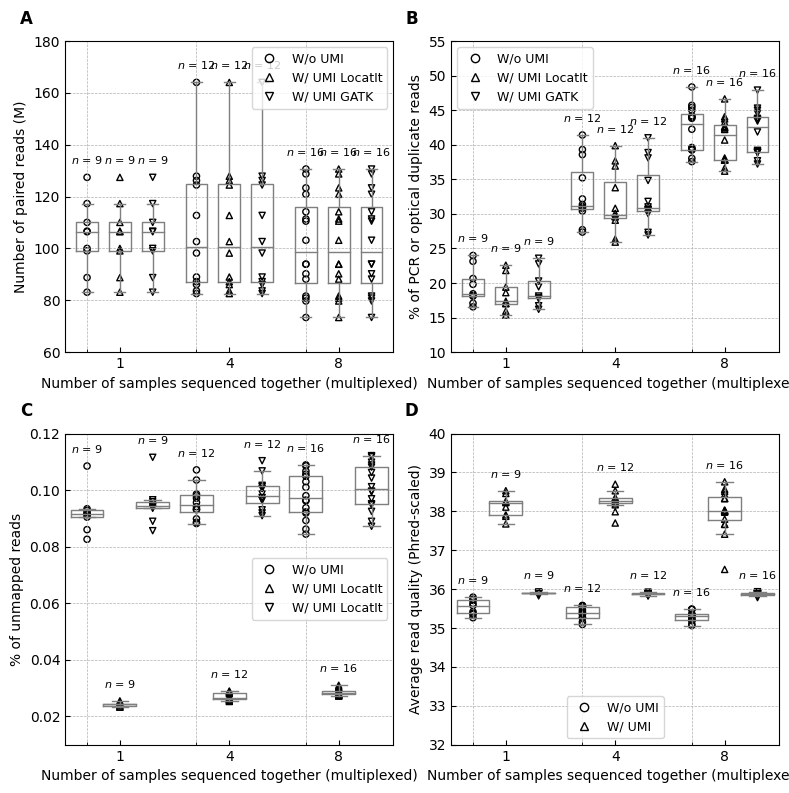

In [20]:
plt.style.use('default')
fig = plt.figure(figsize=(8, 8), dpi = 100)

dedup_types = [(1, 'NOUMI'), (2, 'UMI'), (3, 'UMI_GATK')]
dedup_markers = { 1: 'o', 2: '^', 3: 'v' }
dedup_offsets = { 1: -0.3, 2: 0, 3: 0.3 }
plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]


# Figure A
# ==================== #
ax = fig.add_subplot(2, 2, 1)
for dedup_idx, dedup_type in dedup_types:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Plexing == plexing)]
        ax.scatter([x + dedup_offsets[dedup_idx]] * len(df_n_reads_temp), df_n_reads_temp[f'N_READS_{dedup_type}_M'], 
                marker = dedup_markers[dedup_idx], edgecolor = 'black', facecolor = 'none', s = 20)
# boxplots
bp_data = {1: [], 2: [], 3: []}
bp_positions = {1: [], 2: [], 3: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for dedup_idx, dedup_type in dedup_types:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Plexing == plexing)]
        bp_positions[dedup_idx].append(x + dedup_offsets[dedup_idx])
        bp_data[dedup_idx].append(df_n_reads_temp[f'N_READS_{dedup_type}_M'])
    bx = ax.boxplot(bp_data[dedup_idx], positions = bp_positions[dedup_idx], widths = 0.2,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + dedup_offsets[1] for x in plexing_positions] + [x + dedup_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([60,  180])
# Text annotations
for dedup_idx, dedup_type in dedup_types:
    for x, data in zip(bp_positions[dedup_idx], bp_data[dedup_idx]):
        annotate_sample_size(ax, x, data, 10)
ax.set_ylabel('Number of paired reads (M)')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
legend_elements = [
    Line2D([0], [0], marker = dedup_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = dedup_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI LocatIt'),
    Line2D([0], [0], marker = dedup_markers[3], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI GATK')
]
ax.legend(handles = legend_elements, loc = 1, prop = {'size': 9})


# Figure B
# ==================== #
ax = fig.add_subplot(2, 2, 2)
# scatter plot
for dedup_idx, dedup_type in dedup_types:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Plexing == plexing)]
        ax.scatter([x + dedup_offsets[dedup_idx]] * len(df_n_reads_temp), df_n_reads_temp[f'PERC_DUPLICATED_READS_{dedup_type}'], 
                marker = dedup_markers[dedup_idx], edgecolor = 'black', facecolor = 'none', s = 20)
# boxplots
bp_data = {1: [], 2: [], 3: []}
bp_positions = {1: [], 2: [], 3: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for dedup_idx, dedup_type in dedup_types:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Plexing == plexing)]
        bp_positions[dedup_idx].append(x + dedup_offsets[dedup_idx])
        bp_data[dedup_idx].append(df_n_reads_temp[f'PERC_DUPLICATED_READS_{dedup_type}'])
    bx = ax.boxplot(bp_data[dedup_idx], positions = bp_positions[dedup_idx], widths = 0.2,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + dedup_offsets[1] for x in plexing_positions] + [x + dedup_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([10,  55])
# Text annotations
for dedup_idx, dedup_type in dedup_types:
    for x, data in zip(bp_positions[dedup_idx], bp_data[dedup_idx]):
        annotate_sample_size(ax, x, data, 10)
ax.set_ylabel('% of PCR or optical duplicate reads')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
legend_elements = [
    Line2D([0], [0], marker = dedup_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = dedup_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI LocatIt'),
    Line2D([0], [0], marker = dedup_markers[3], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI GATK') 
]
ax.legend(handles = legend_elements, loc = 2, prop = {'size': 9})


# Figure C
# ==================== #
ax = fig.add_subplot(2, 2, 3)
# scatter plot
for dedup_idx, dedup_type in dedup_types:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Plexing == plexing)]
        ax.scatter([x + dedup_offsets[dedup_idx]] * len(df_n_reads_temp), df_n_reads_temp[f'PERC_UNMAPPED_READS_{dedup_type}'], 
                marker = dedup_markers[dedup_idx], edgecolor = 'black', facecolor = 'none', s = 20)
# boxplots
bp_data = {1: [], 2: [], 3: []}
bp_positions = {1: [], 2: [], 3: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for dedup_idx, dedup_type in dedup_types:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Plexing == plexing)]
        bp_positions[dedup_idx].append(x + dedup_offsets[dedup_idx])
        bp_data[dedup_idx].append(df_n_reads_temp[f'PERC_UNMAPPED_READS_{dedup_type}'])
    bx = ax.boxplot(bp_data[dedup_idx], positions = bp_positions[dedup_idx], widths = 0.3,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + dedup_offsets[1] for x in plexing_positions] + [x + dedup_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.01,  0.12])
# Text annotations
for dedup_idx, dedup_type in dedup_types:
    for x, data in zip(bp_positions[dedup_idx], bp_data[dedup_idx]):
        annotate_sample_size(ax, x, data, 10)
ax.set_ylabel('% of unmapped reads')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
legend_elements = [
    Line2D([0], [0], marker = dedup_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = dedup_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI LocatIt'),
    Line2D([0], [0], marker = dedup_markers[3], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI LocatIt')
]
ax.legend(handles = legend_elements, loc = 7, prop = {'size': 9})

# Figure D
# ==================== #
ax = fig.add_subplot(2, 2, 4)
# scatter plot
for dedup_idx, dedup_type in dedup_types:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Plexing == plexing)]
        ax.scatter([x + dedup_offsets[dedup_idx]] * len(df_n_reads_temp), df_n_reads_temp[f'AVG_BQ_{dedup_type}'], 
                marker = dedup_markers[dedup_idx], edgecolor = 'black', facecolor = 'none', s = 20)
# boxplots
bp_data = {1: [], 2: [], 3: []}
bp_positions = {1: [], 2: [], 3: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for dedup_idx, dedup_type in dedup_types:
    for x, plexing in zip(plexing_positions, plexings):
        df_n_reads_temp = df_n_reads[(df_n_reads.Plexing == plexing)]
        bp_positions[dedup_idx].append(x + dedup_offsets[dedup_idx])
        bp_data[dedup_idx].append(df_n_reads_temp[f'AVG_BQ_{dedup_type}'])
    bx = ax.boxplot(bp_data[dedup_idx], positions = bp_positions[dedup_idx], widths = 0.3,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + dedup_offsets[1] for x in plexing_positions] + [x + dedup_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([32,  40])
# Text annotations
for dedup_idx, dedup_type in dedup_types:
    for x, data in zip(bp_positions[dedup_idx], bp_data[dedup_idx]):
        annotate_sample_size(ax, x, data, 10)
ax.set_ylabel('Average read quality (Phred-scaled)')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
legend_elements = [
    Line2D([0], [0], marker = dedup_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = dedup_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI')
]
ax.legend(handles = legend_elements, loc = 8, prop = {'size': 9})

plt.tight_layout()
plt.show()
